# XJTU

/home/richie_thu/miniconda3/envs/TS/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/15 [00:00<?, ?it/s]

load/home/richie_thu/_Richie_project/U-PHM/dataset/XJTU/35Hz12kN/Bearing1_1


100%|██████████| 123/123 [00:01<00:00, 112.49it/s]


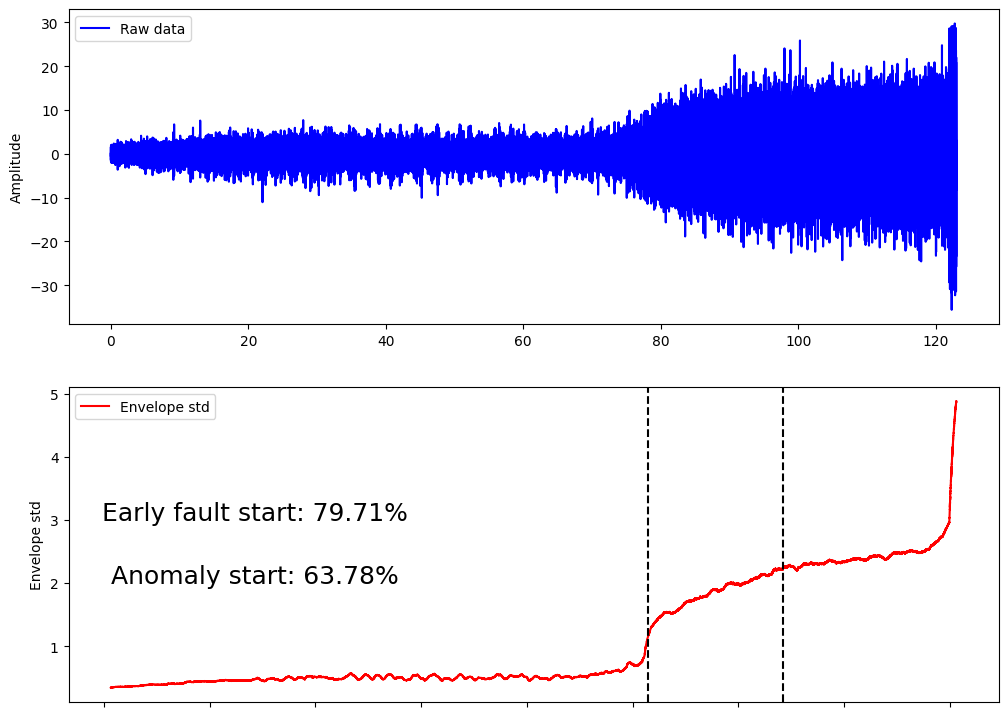

  7%|▋         | 1/15 [00:02<00:32,  2.33s/it]

load/home/richie_thu/_Richie_project/U-PHM/dataset/XJTU/37.5Hz11kN/Bearing2_1


100%|██████████| 491/491 [00:03<00:00, 138.01it/s]


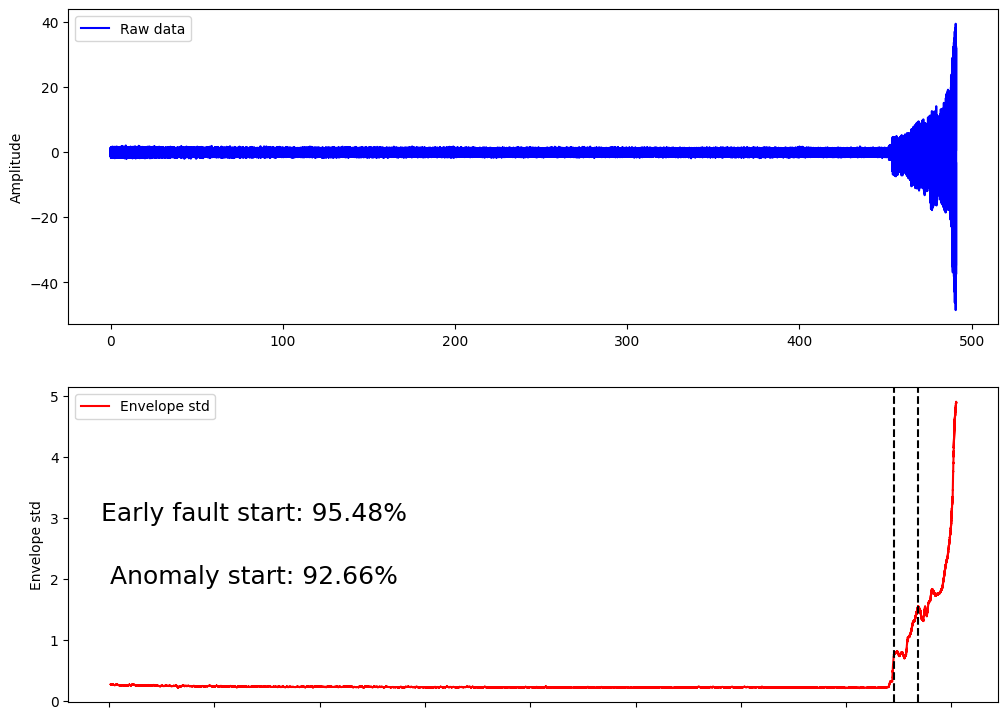

 13%|█▎        | 2/15 [00:09<01:08,  5.29s/it]

load/home/richie_thu/_Richie_project/U-PHM/dataset/XJTU/40Hz10kN/Bearing3_1


 13%|█▎        | 2/15 [00:11<01:16,  5.92s/it]


KeyboardInterrupt: 

In [1]:
import os
import numpy as np
import pandas as pd
import glob
import re
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import multiprocessing as mp
import matplotlib.pyplot as plt
from tqdm import tqdm
import argparse
from scipy.signal import hilbert
from scipy.stats import kurtosis

def load_csv(args, file_name):
    all_data = []

    if '1_' in file_name:
        path_data = args.root_path + args.data_path + '35Hz12kN/' + file_name
    elif '2_' in file_name:
        path_data = args.root_path + args.data_path + '37.5Hz11kN/' + file_name
    elif '3_' in file_name:
        path_data = args.root_path + args.data_path + '40Hz10kN/' + file_name
        
    all_file = os.listdir(path_data)
    all_file.sort(key=lambda l: int(re.findall('\d+', l)[0]))
    
    print('load' + f'{path_data}')
    for name in tqdm(all_file):
        raw_data = pd.read_csv(os.path.join(path_data, name))
        all_data.append(raw_data)
    return all_data

def reshape_data(data):
    reshaped_data = pd.concat(data, axis=0, ignore_index=True)
    return reshaped_data

# def plot_data(data,file):
#     plt.plot(data)
#     plt.legend(file)
#     plt.show()
#     plt.savefig(file+'.svg')
        #     
     
# def plot_data(data, file, window_size=32768, consecutive_count=10):
#     # 计算前10个窗口的标准差
#     window_std = []
#     for i in range(10):
#         window = data[i*window_size:(i+1)*window_size]
#         std = window.std()
#         window_std.append(std)
#     std_base = np.mean(window_std)

#     # 找到第一个异常点
#     threshold = 3 * std_base
#     anomalies = abs(data - data.mean()) > threshold
#     anomaly_start = anomalies.idxmax()

#     # # 检测连续的异常点
#     # consecutive = 0
#     # for i in range(anomaly_start, len(data)):
#     #     if anomalies[i]:
#     #         consecutive += 1
#     #     else:
#     #         consecutive = 0
#     #     if consecutive == consecutive_count:
#     #         anomaly_end = i
#     #         break

#     # 绘制异常点和标记
#     fig, ax = plt.subplots(figsize=(12, 6))
#     ax.plot(data, color='blue', label=file)
#     ax.axvline(anomaly_start.all(), color='black', linestyle='--')
#     # ax.axhline(data.iloc[anomaly_start.all], color='red', linestyle='--')
#     # ax.axvline(anomaly_end, color='black', linestyle='--')
#     # ax.axhline(data[anomaly_end], color='red', linestyle='--')
#     # ax.text(0.8, 0.9, 'Anomaly start: {:.2f}%'.format(anomaly_start / len(data) * 100),
#     #         ha='center', va='center', transform=ax.transAxes, fontsize=12, color='black')
#     # ax.text(0.8, 0.8, 'Anomaly end: {:.2f}%'.format(anomaly_end / len(data) * 100),
#     #         ha='center', va='center', transform=ax.transAxes, fontsize=12, color='black')
#     ax.axis('off')
#     ax.legend(loc='upper left')
#     plt.show()
def plot_data(data, file, window_size=32768):
    # 计算包络谱的频域峭度
    analytic_signal = hilbert(data)
    amplitude_envelope = pd.DataFrame(np.abs(analytic_signal[:,0]))
    # # spectrum, freqs, _, _ = plt.specgram(amplitude_envelope, NFFT=window_size, Fs=1, noverlap=0, mode='magnitude')
    # kurt = pd.DataFrame(spectrum).apply(kurtosis, raw=True)
    window_std = []
    for i in range(10):
        window = amplitude_envelope[i*window_size:(i+1)*window_size]
        std = window.std()
        window_std.append(std)
    std_base = np.mean(window_std)
    
    window_size = window_size
    std = amplitude_envelope.rolling(window_size).std()
    mean = amplitude_envelope.rolling(window_size).mean()
        
    # 找到第一个异常点
    threshold = 3 * std_base
    anomalies = abs(std) > threshold
    anomaly_start = anomalies.idxmax()

    # 找到第一个早期故障点
    
    threshold_fault = 6 * std_base
    anomalies_fault = abs(std) > threshold_fault
    fault_start = anomalies_fault.idxmax()
    
    
    
    std = pd.DataFrame(amplitude_envelope).rolling(window_size).std()
    lenth = len(analytic_signal)
    time = lenth//window_size
    time = np.linspace(0, time,lenth)
    
    # 绘制原始信号和包络谱的频域峭度曲线
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 9))
    ax[0].plot(time,data.iloc[:,0], color='blue', label='Raw data')
    ax[0].set_ylabel('Amplitude')
    ax[0].legend(loc='upper left')
    
    ax[1].plot(std, color='red', label='Envelope std')
    ax[1].set_ylabel('Envelope std')
    ax[1].axes.xaxis.set_ticklabels([])

    ax[1].legend(loc='upper left')



    ax[1].axvline(anomaly_start[0], color='black', linestyle='--')
    # 保存图像为svg格式
    file_name = file.split('.')[0]
    
    ax[1].text(0.2, 0.4, 'Anomaly start: {:.2f}%'.format(anomaly_start[0] / lenth * 100),
             ha='center', va='center', transform=ax[1].transAxes, fontsize=18, color='black')
    ax[1].axvline(fault_start[0], color='black', linestyle='--')
    # 保存图像为svg格式
    file_name = file.split('.')[0]
    
    ax[1].text(0.2, 0.6, 'Early fault start: {:.2f}%'.format(fault_start[0] / lenth * 100),
             ha='center', va='center', transform=ax[1].transAxes, fontsize=18, color='black')

    
    fig.savefig(file_name + f'ws{window_size}.svg', format='svg')

    plt.show()

args = argparse.Namespace(
    root_path='/home/richie_thu/_Richie_project/U-PHM/',
    data_path='dataset/XJTU/',
    dataset='XJTU',
    batch_size=64,
    shuffle_flag=True,
    num_workers=0,
    drop_last=True,
    size=1024,
    pred=1,
    scale=True,
    sample_freq=20480.0,
    bearing = ['Bearing1_1','Bearing2_1','Bearing3_1'] + ['Bearing1_2','Bearing1_3','Bearing1_4','Bearing1_5',
                        'Bearing2_2','Bearing2_3','Bearing2_4','Bearing2_5',
                        'Bearing3_2','Bearing3_3','Bearing3_4','Bearing3_5']
)
for file in tqdm(args.bearing):
    
    all_data = load_csv(args,file)
    reshaped_data = reshape_data(all_data)
    plot_data(reshaped_data,file)
    
# args = argparse.Namespace(
#     root_path='/home/richie_thu/_Richie_project/U-PHM/',
#     data_path='dataset/FEMTO-ST/',
#     dataset='FEMTO-ST',
#     batch_size=64,
#     shuffle_flag=True,
#     num_workers=0,
#     drop_last=True,
#     size=1024,
#     pred=1,
#     scale=True,
#     sample_freq=20480.0,
#     bearing = ['Bearing1_1','Bearing1_2','Bearing2_1','Bearing2_2','Bearing3_1','Bearing3_2'] + ['Bearing1_3','Bearing1_4', 'Bearing1_5','Bearing1_6','Bearing1_7',
#                         'Bearing2_3', 'Bearing2_4', 'Bearing2_5', 'Bearing2_6', 'Bearing2_7',
#                         'Bearing3_3']
# )
# for file in tqdm(args.bearing):
    
#     all_data = load_csv(args,file)
#     reshaped_data = reshape_data(all_data)
#     plot_data(reshaped_data,file,window_size=25600)
 

# FEMTO

In [ ]:
import os
import numpy as np
import pandas as pd
import glob
import re
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import multiprocessing as mp
import matplotlib.pyplot as plt
from tqdm import tqdm
import argparse
from scipy.signal import hilbert
from scipy.stats import kurtosis

def load_csv(args, file_name):
    all_data = []

    if '1_' in file_name:
        path_data = args.root_path + args.data_path + '35Hz12kN/' + file_name
    elif '2_' in file_name:
        path_data = args.root_path + args.data_path + '37.5Hz11kN/' + file_name
    elif '3_' in file_name:
        path_data = args.root_path + args.data_path + '40Hz10kN/' + file_name
        
    Learning_set = os.listdir(args.root_path + args.data_path + '/Learning_set')
    Full_Test_Set = os.listdir(args.root_path + args.data_path + '/Full_Test_Set')
    # self.bearing = 'Bearing' + self.bearing
    for i,target_bearing in enumerate(sorted(Learning_set)):
        if file_name == target_bearing:

            path_data = args.root_path + args.data_path +'Learning_set/' + file_name
            break  
        else:

            path_data = args.root_path + args.data_path +'Full_Test_Set/' + file_name    
                  
    all_file = os.listdir(path_data)
    all_file = list(filter(lambda x: 'acc' in x and 'temp' not in x, os.listdir(path_data)))
    all_file.sort(key=lambda l: int(re.findall('\d+', l)[0]))
    
    print('load' + f'{path_data}')
    for name in tqdm(all_file):

        
        if file_name == 'Bearing1_4': # solve a BUG from dataset
            raw_data = pd.read_csv(os.path.join(path_data, name),header=None)[0].str.split(';', expand=True).loc[:,4:6]
        else:
            
            raw_data = pd.read_csv(os.path.join(path_data, name),header=None).loc[:,4:6] # NO sep='\t' for FEMTO

        
        all_data.append(raw_data)
    return all_data

def reshape_data(data):
    reshaped_data = pd.concat(data, axis=0, ignore_index=True)
    return reshaped_data


def plot_data(data, file, window_size=32768):
    # 计算包络谱的频域峭度
    analytic_signal = hilbert(data)
    amplitude_envelope = pd.DataFrame(np.abs(analytic_signal[:,0]))
    # # spectrum, freqs, _, _ = plt.specgram(amplitude_envelope, NFFT=window_size, Fs=1, noverlap=0, mode='magnitude')
    # kurt = pd.DataFrame(spectrum).apply(kurtosis, raw=True)
    window_std = []
    for i in range(100):
        window = amplitude_envelope[i*window_size:(i+1)*window_size]
        std = window.std()
        window_std.append(std)
    std_base = np.mean(window_std)
    
    window_size = window_size
    std = amplitude_envelope.rolling(window_size).std()
    mean = amplitude_envelope.rolling(window_size).mean()
        
    # 找到第一个异常点
    threshold = 3 * std_base
    anomalies = abs(std) > threshold
    anomaly_start = anomalies.idxmax()

    # 找到第一个早期故障点
    
    threshold_fault = 6 * std_base
    anomalies_fault = abs(std) > threshold_fault
    fault_start = anomalies_fault.idxmax()
    
    
    
    std = pd.DataFrame(amplitude_envelope).rolling(window_size).std()
    lenth = len(analytic_signal)
    time = lenth//window_size
    time = np.linspace(0, time,lenth)
    
    # 绘制原始信号和包络谱的频域峭度曲线
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 9))
    ax[0].plot(time,data.iloc[:,0], color='blue', label='Raw data')
    ax[0].set_ylabel('Amplitude')
    ax[0].legend(loc='upper left')
    
    ax[1].plot(std, color='red', label='Envelope std')
    ax[1].set_ylabel('Envelope std')
    ax[1].axes.xaxis.set_ticklabels([])

    ax[1].legend(loc='upper left')



    ax[1].axvline(anomaly_start[0], color='black', linestyle='--')
    # 保存图像为svg格式
    file_name = file.split('.')[0]
    
    ax[1].text(0.2, 0.4, 'Anomaly start: {:.2f}%'.format(anomaly_start[0] / lenth * 100),
             ha='center', va='center', transform=ax[1].transAxes, fontsize=12, color='black')
    ax[1].axvline(fault_start[0], color='black', linestyle='--')
    # 保存图像为svg格式
    file_name = file.split('.')[0]
    
    ax[1].text(0.2, 0.6, 'Early fault start: {:.2f}%'.format(fault_start[0] / lenth * 100),
             ha='center', va='center', transform=ax[1].transAxes, fontsize=12, color='black')

    
    fig.savefig(file_name + f'ws{window_size}.svg', format='svg')

    plt.show()

# args = argparse.Namespace(
#     root_path='/home/richie_thu/_Richie_project/U-PHM/',
#     data_path='dataset/XJTU/',
#     dataset='XJTU',
#     batch_size=64,
#     shuffle_flag=True,
#     num_workers=0,
#     drop_last=True,
#     size=1024,
#     pred=1,
#     scale=True,
#     sample_freq=20480.0,
#     bearing = ['Bearing1_1','Bearing2_1','Bearing3_1'] + ['Bearing1_2','Bearing1_3','Bearing1_4','Bearing1_5',
#                         'Bearing2_2','Bearing2_3','Bearing2_4','Bearing2_5',
#                         'Bearing3_2','Bearing3_3','Bearing3_4','Bearing3_5']
# )
# for file in tqdm(args.bearing):
    
#     all_data = load_csv(args,file)
#     reshaped_data = reshape_data(all_data)
#     plot_data(reshaped_data,file)
    
args = argparse.Namespace(
    root_path='/home/richie_thu/_Richie_project/U-PHM/',
    data_path='dataset/FEMTO-ST/',
    dataset='FEMTO-ST',
    batch_size=64,
    shuffle_flag=True,
    num_workers=0,
    drop_last=True,
    size=1024,
    pred=1,
    scale=True,
    sample_freq=20480.0,
    bearing = ['Bearing1_1','Bearing1_2','Bearing2_1','Bearing2_2','Bearing3_1','Bearing3_2'] + ['Bearing1_3','Bearing1_4', 'Bearing1_5','Bearing1_6','Bearing1_7',
                        'Bearing2_3', 'Bearing2_4', 'Bearing2_5', 'Bearing2_6', 'Bearing2_7',
                        'Bearing3_3']
)
for file in tqdm(args.bearing):
    if file != 'Bearing1_4':
        continue
    all_data = load_csv(args,file)
    reshaped_data = reshape_data(all_data)
    plot_data(reshaped_data,file,window_size=2560)
 



  0%|          | 0/17 [00:00<?, ?it/s]

load/home/richie_thu/_Richie_project/U-PHM/dataset/FEMTO-ST/Full_Test_Set/Bearing1_4


  0%|          | 0/17 [00:00<?, ?it/s]

load/home/richie_thu/_Richie_project/U-PHM/dataset/FEMTO-ST/Learning_set/Bearing1_1


100%|██████████| 2803/2803 [13:59<00:00,  3.34it/s] 


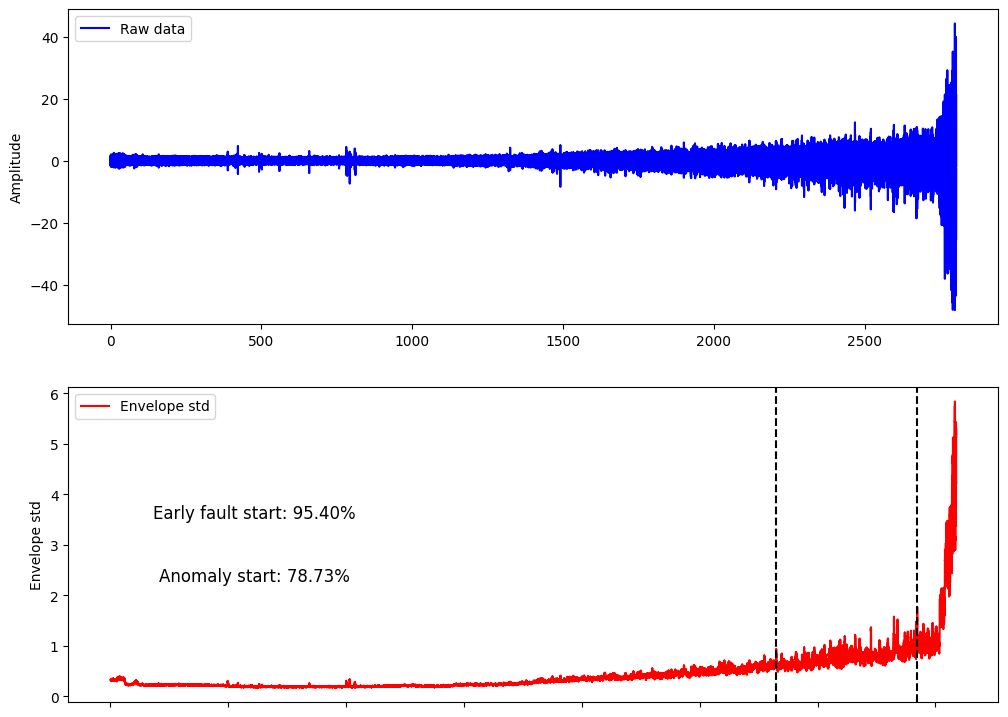

  6%|▌         | 1/17 [14:02<3:44:34, 842.15s/it]

load/home/richie_thu/_Richie_project/U-PHM/dataset/FEMTO-ST/Learning_set/Bearing1_2


100%|██████████| 871/871 [00:01<00:00, 476.95it/s]


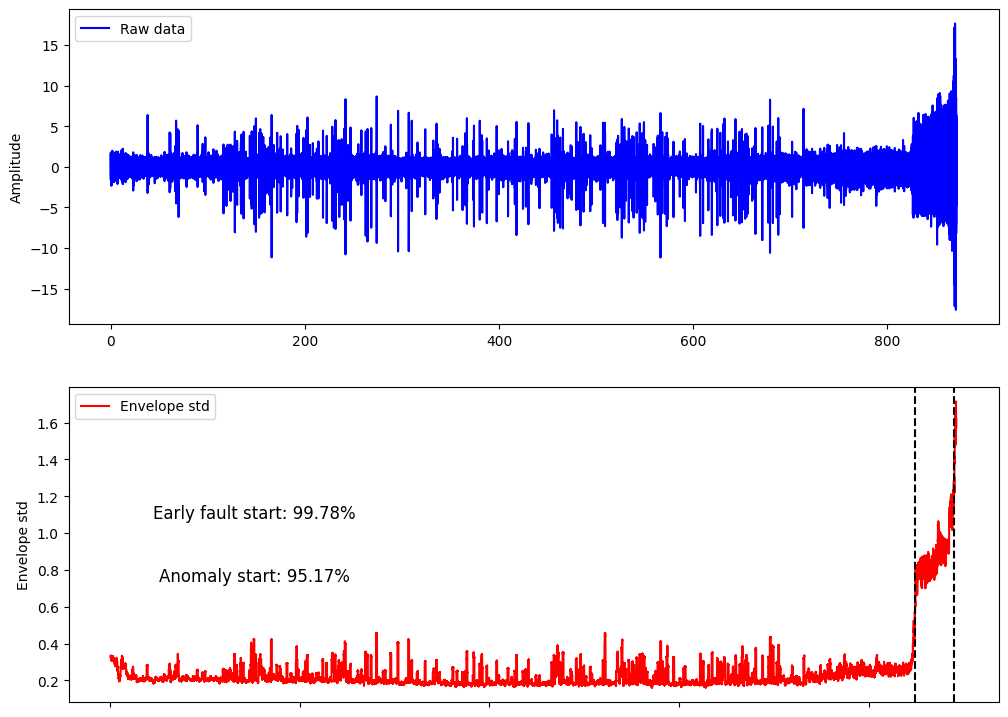

 12%|█▏        | 2/17 [14:04<1:27:05, 348.40s/it]

load/home/richie_thu/_Richie_project/U-PHM/dataset/FEMTO-ST/Learning_set/Bearing2_1


100%|██████████| 911/911 [00:01<00:00, 488.06it/s]


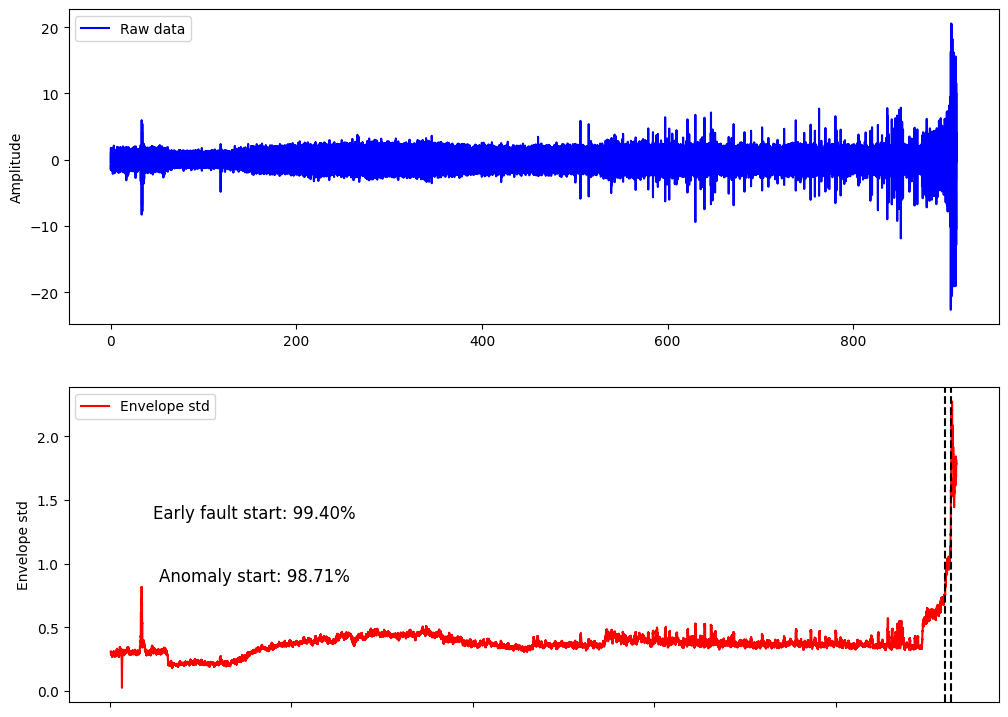

 18%|█▊        | 3/17 [14:07<44:28, 190.60s/it]  

load/home/richie_thu/_Richie_project/U-PHM/dataset/FEMTO-ST/Learning_set/Bearing2_2


100%|██████████| 797/797 [00:01<00:00, 469.73it/s]


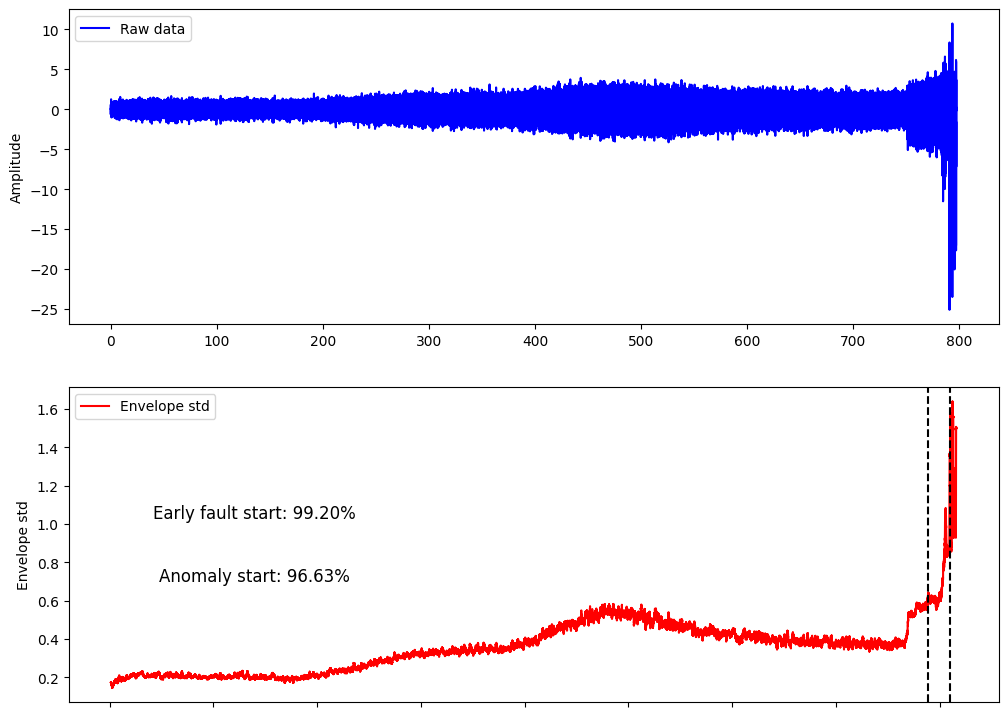

 24%|██▎       | 4/17 [14:10<25:12, 116.38s/it]

load/home/richie_thu/_Richie_project/U-PHM/dataset/FEMTO-ST/Learning_set/Bearing3_1


100%|██████████| 515/515 [00:01<00:00, 481.19it/s]


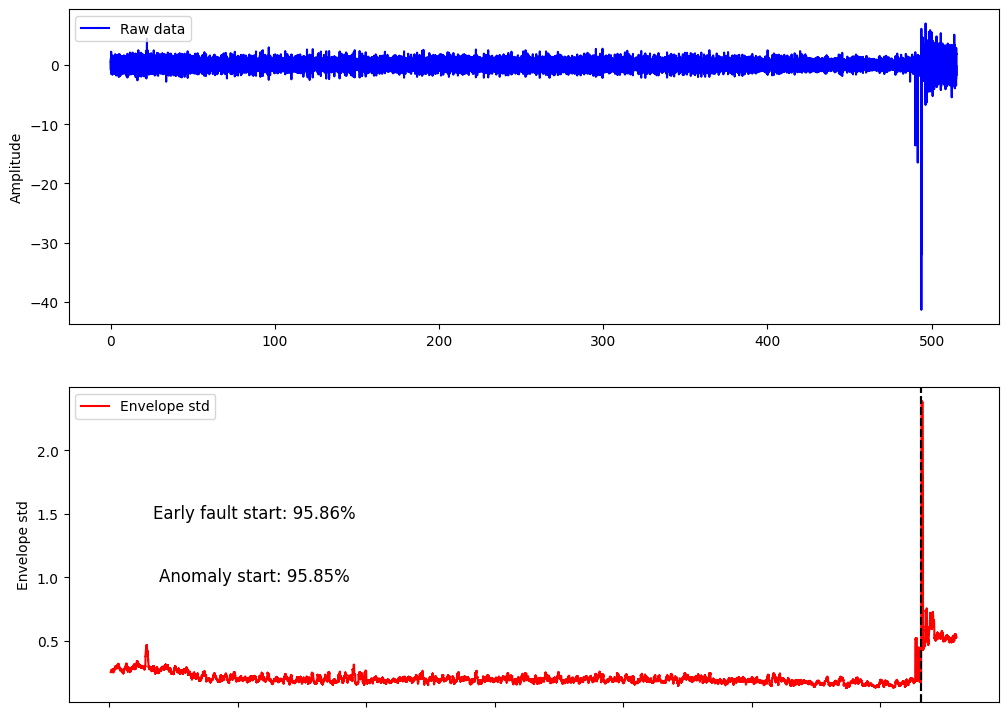

 29%|██▉       | 5/17 [14:12<15:00, 75.07s/it] 

load/home/richie_thu/_Richie_project/U-PHM/dataset/FEMTO-ST/Learning_set/Bearing3_2


100%|██████████| 1637/1637 [00:03<00:00, 470.45it/s]


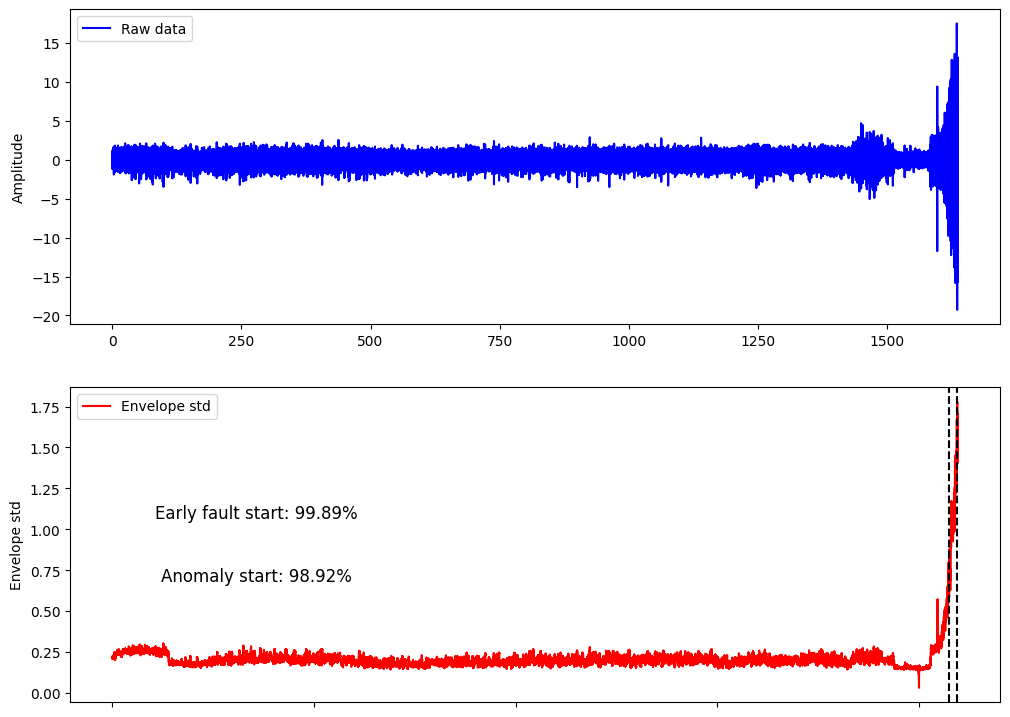

 35%|███▌      | 6/17 [14:17<09:23, 51.25s/it]

load/home/richie_thu/_Richie_project/U-PHM/dataset/FEMTO-ST/Full_Test_Set/Bearing1_3


100%|██████████| 2375/2375 [00:05<00:00, 452.92it/s]


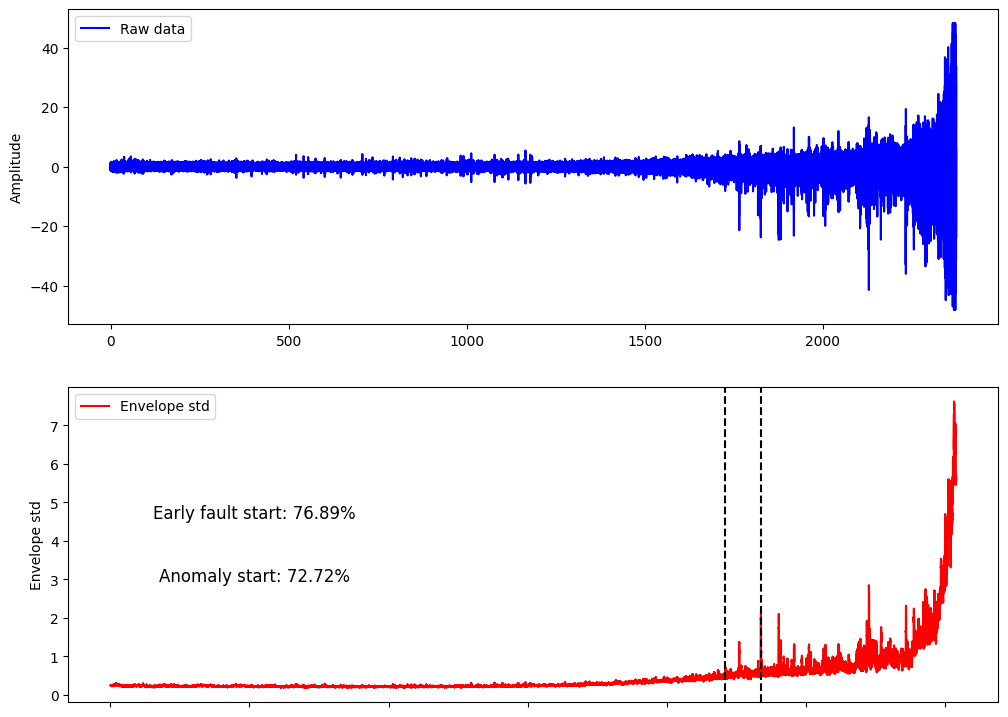

 41%|████      | 7/17 [14:24<06:08, 36.87s/it]

load/home/richie_thu/_Richie_project/U-PHM/dataset/FEMTO-ST/Full_Test_Set/Bearing1_4


100%|██████████| 1428/1428 [00:11<00:00, 127.77it/s]


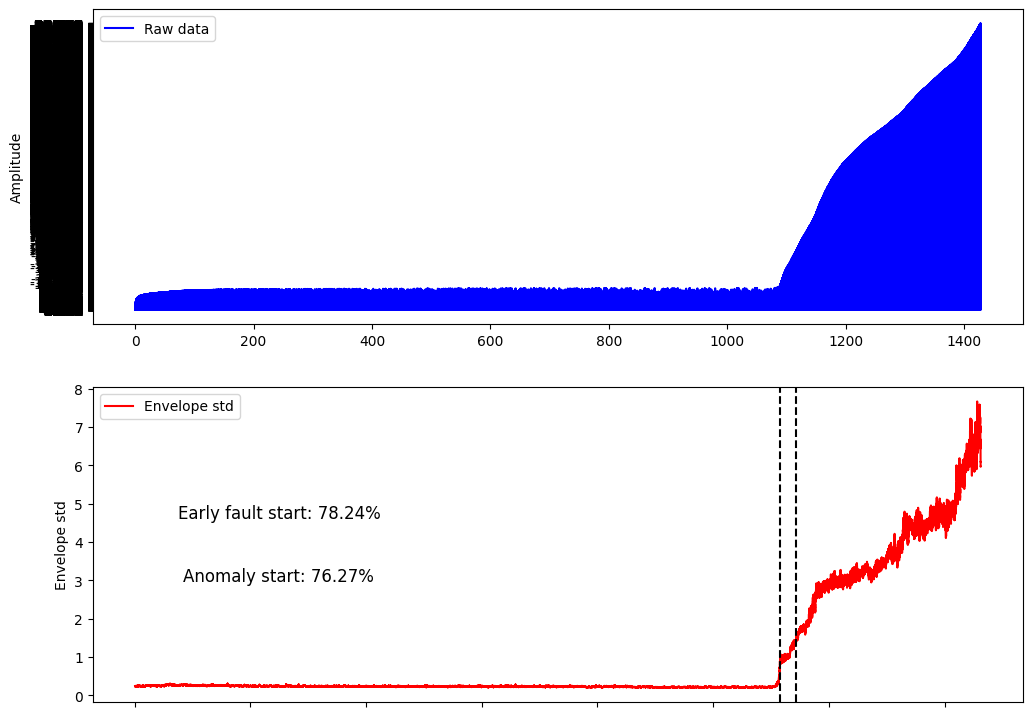

 47%|████▋     | 8/17 [19:27<18:13, 121.55s/it]

load/home/richie_thu/_Richie_project/U-PHM/dataset/FEMTO-ST/Full_Test_Set/Bearing1_5


100%|██████████| 2463/2463 [00:04<00:00, 511.91it/s]


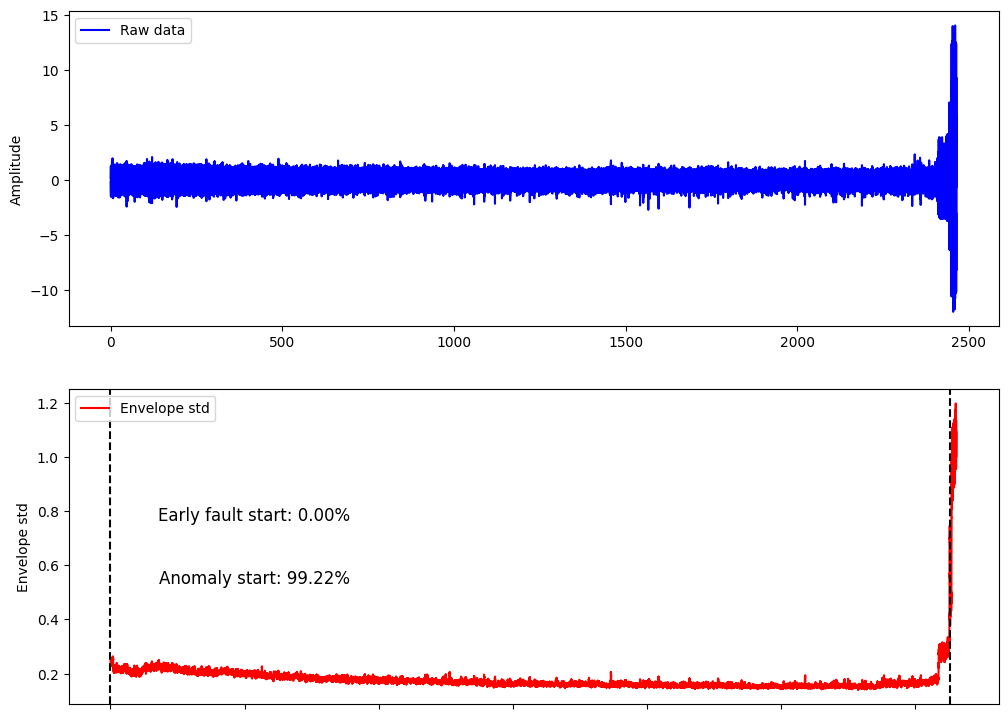

 53%|█████▎    | 9/17 [19:34<11:26, 85.81s/it] 

load/home/richie_thu/_Richie_project/U-PHM/dataset/FEMTO-ST/Full_Test_Set/Bearing1_6


100%|██████████| 2448/2448 [00:04<00:00, 527.98it/s]


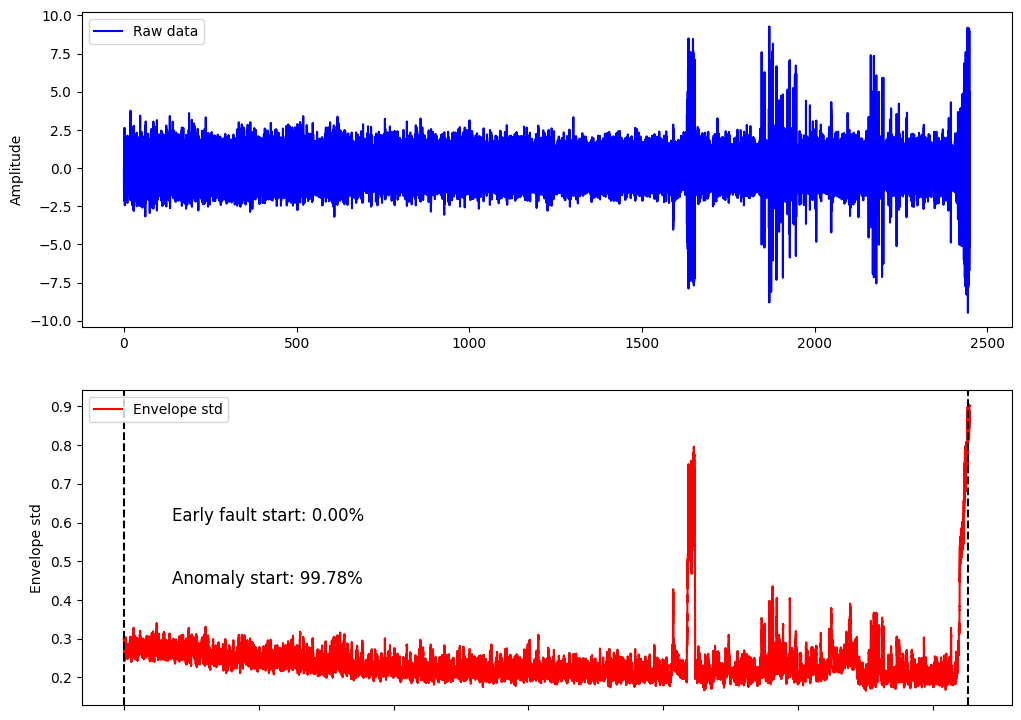

 59%|█████▉    | 10/17 [19:41<07:10, 61.44s/it]

load/home/richie_thu/_Richie_project/U-PHM/dataset/FEMTO-ST/Full_Test_Set/Bearing1_7


100%|██████████| 2259/2259 [00:04<00:00, 538.88it/s]


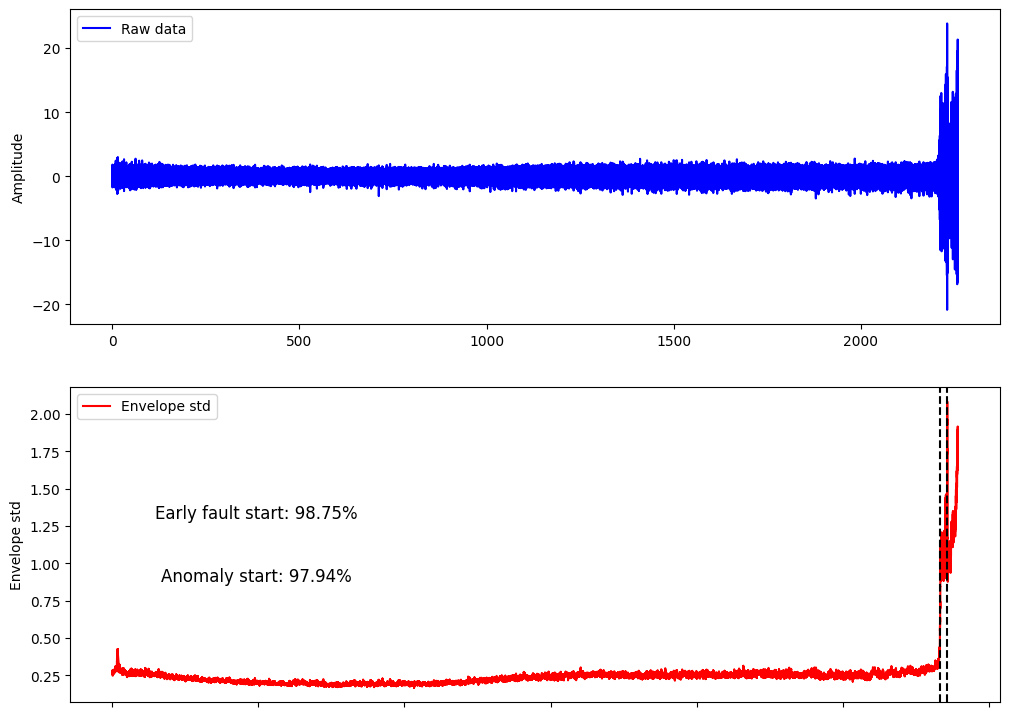

 65%|██████▍   | 11/17 [19:47<04:27, 44.54s/it]

load/home/richie_thu/_Richie_project/U-PHM/dataset/FEMTO-ST/Full_Test_Set/Bearing2_3


100%|██████████| 1955/1955 [00:04<00:00, 440.21it/s]


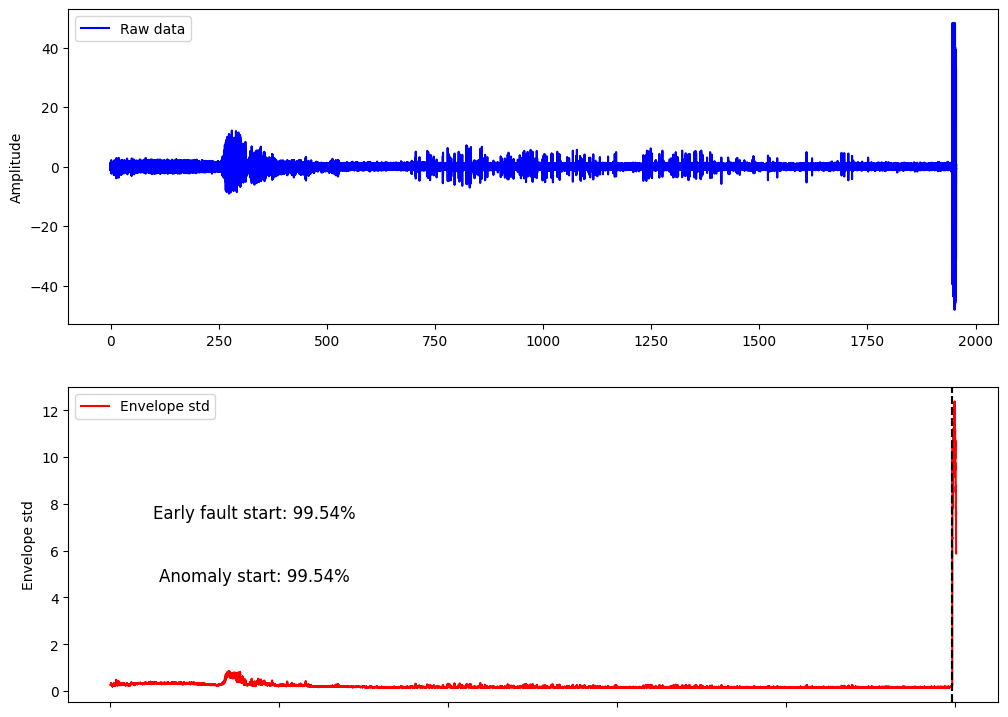

 71%|███████   | 12/17 [19:53<02:44, 32.88s/it]

load/home/richie_thu/_Richie_project/U-PHM/dataset/FEMTO-ST/Full_Test_Set/Bearing2_4


100%|██████████| 751/751 [00:01<00:00, 439.78it/s]


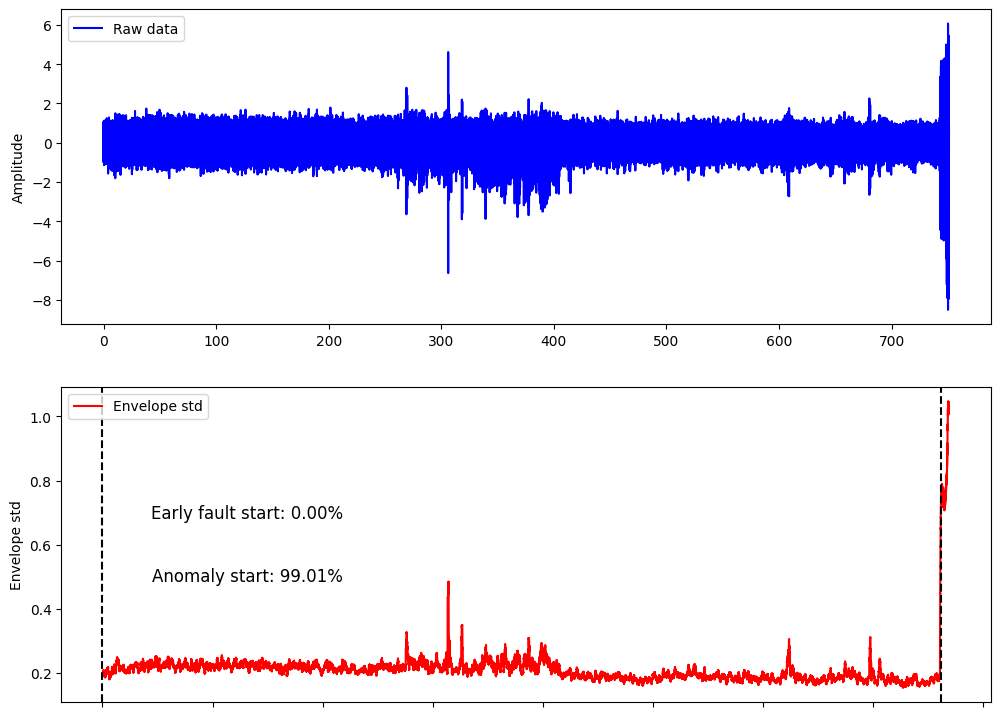

 76%|███████▋  | 13/17 [19:56<01:34, 23.71s/it]

load/home/richie_thu/_Richie_project/U-PHM/dataset/FEMTO-ST/Full_Test_Set/Bearing2_5


100%|██████████| 2311/2311 [00:05<00:00, 446.59it/s]


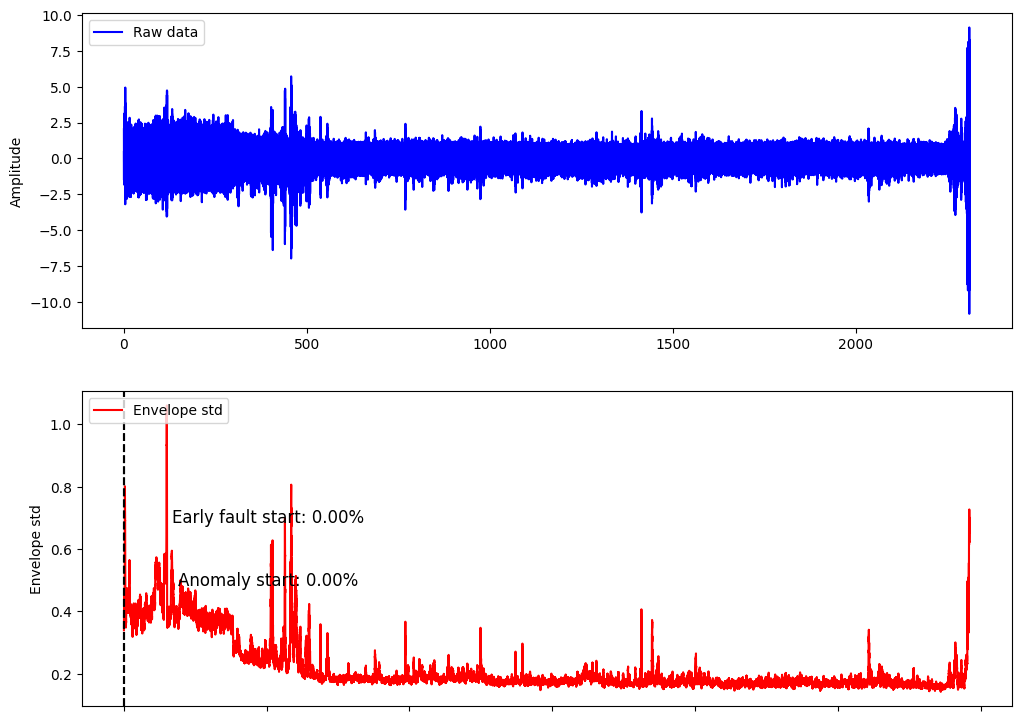

 82%|████████▏ | 14/17 [20:03<00:56, 18.74s/it]

load/home/richie_thu/_Richie_project/U-PHM/dataset/FEMTO-ST/Full_Test_Set/Bearing2_6


100%|██████████| 701/701 [00:01<00:00, 533.39it/s]


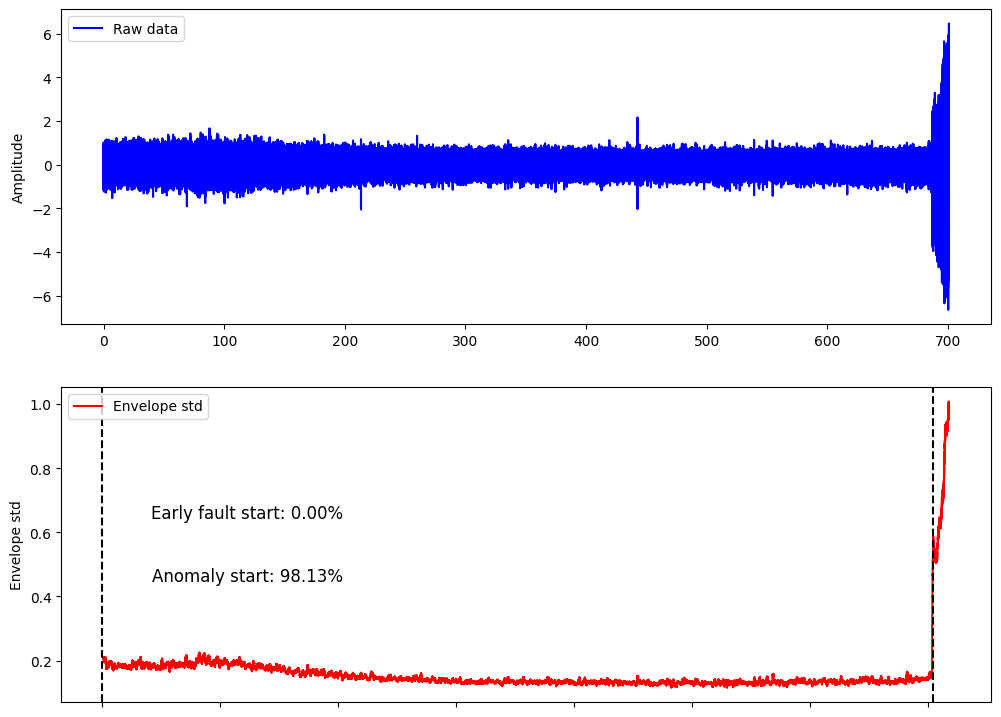

 88%|████████▊ | 15/17 [20:05<00:27, 13.75s/it]

load/home/richie_thu/_Richie_project/U-PHM/dataset/FEMTO-ST/Full_Test_Set/Bearing2_7


100%|██████████| 230/230 [00:00<00:00, 513.59it/s]


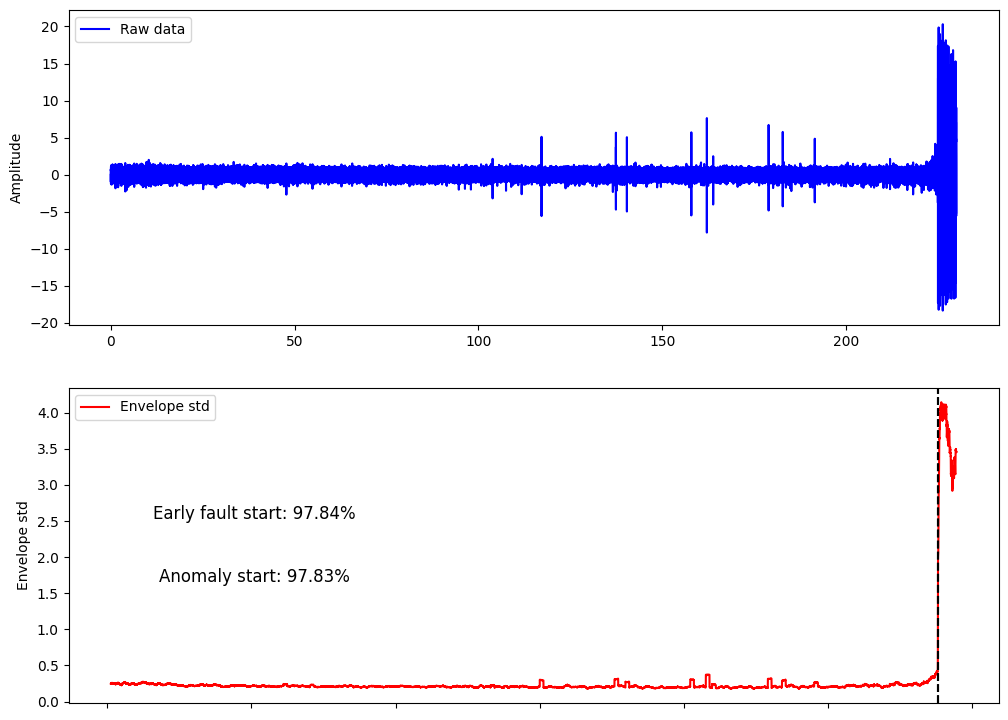

 94%|█████████▍| 16/17 [20:06<00:09,  9.89s/it]

load/home/richie_thu/_Richie_project/U-PHM/dataset/FEMTO-ST/Full_Test_Set/Bearing3_3


100%|██████████| 434/434 [00:00<00:00, 532.19it/s]


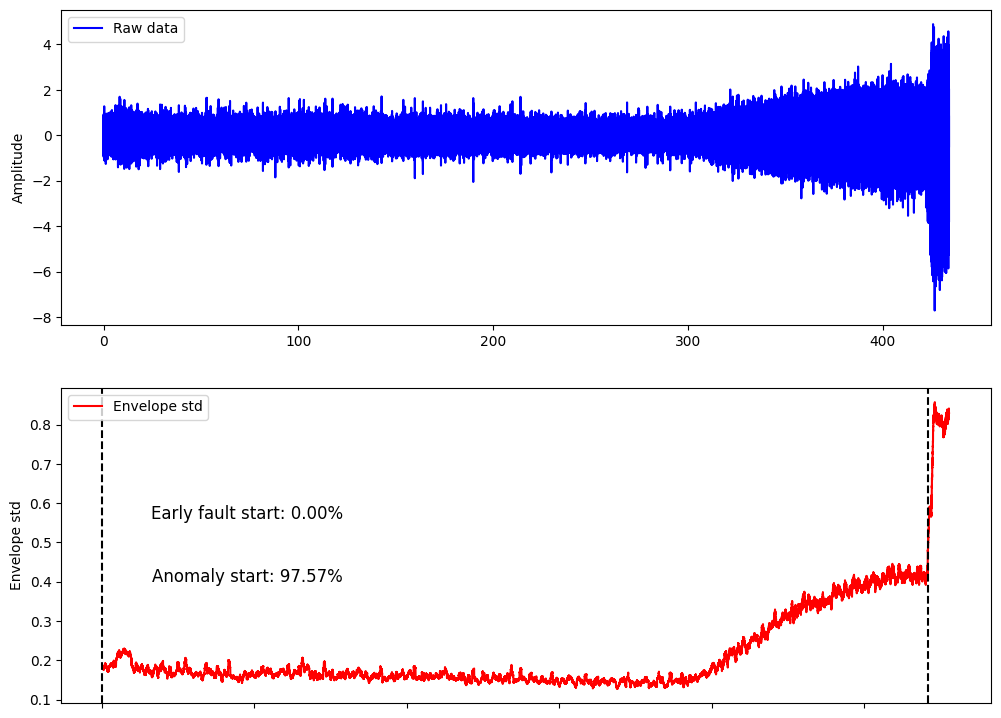

100%|██████████| 17/17 [20:08<00:00, 71.07s/it]


In [2]:
import os
import numpy as np
import pandas as pd
import glob
import re
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import multiprocessing as mp
import matplotlib.pyplot as plt
from tqdm import tqdm
import argparse
from scipy.signal import hilbert
from scipy.stats import kurtosis

def load_csv(args, file_name):
    all_data = []

    if '1_' in file_name:
        path_data = args.root_path + args.data_path + '35Hz12kN/' + file_name
    elif '2_' in file_name:
        path_data = args.root_path + args.data_path + '37.5Hz11kN/' + file_name
    elif '3_' in file_name:
        path_data = args.root_path + args.data_path + '40Hz10kN/' + file_name
        
    Learning_set = os.listdir(args.root_path + args.data_path + '/Learning_set')
    Full_Test_Set = os.listdir(args.root_path + args.data_path + '/Full_Test_Set')
    # self.bearing = 'Bearing' + self.bearing
    for i,target_bearing in enumerate(sorted(Learning_set)):
        if file_name == target_bearing:

            path_data = args.root_path + args.data_path +'Learning_set/' + file_name
            break  
        else:

            path_data = args.root_path + args.data_path +'Full_Test_Set/' + file_name    
                  
    all_file = os.listdir(path_data)
    all_file = list(filter(lambda x: 'acc' in x and 'temp' not in x, os.listdir(path_data)))
    all_file.sort(key=lambda l: int(re.findall('\d+', l)[0]))
    
    print('load' + f'{path_data}')
    for name in tqdm(all_file):

        
        if file_name == 'Bearing1_4': # solve a BUG from dataset
            raw_data = pd.read_csv(os.path.join(path_data, name),header=None)[0].str.split(';', expand=True).loc[:,4:6]
        else:
            
            raw_data = pd.read_csv(os.path.join(path_data, name),header=None).loc[:,4:6] # NO sep='\t' for FEMTO

        
        all_data.append(raw_data)
    return all_data

def reshape_data(data):
    reshaped_data = pd.concat(data, axis=0, ignore_index=True)
    return reshaped_data


def plot_data(data, file, window_size=32768):
    # 计算包络谱的频域峭度
    analytic_signal = hilbert(data)
    amplitude_envelope = pd.DataFrame(np.abs(analytic_signal[:,0]))
    # # spectrum, freqs, _, _ = plt.specgram(amplitude_envelope, NFFT=window_size, Fs=1, noverlap=0, mode='magnitude')
    # kurt = pd.DataFrame(spectrum).apply(kurtosis, raw=True)
    window_std = []
    for i in range(100):
        window = amplitude_envelope[i*window_size:(i+1)*window_size]
        std = window.std()
        window_std.append(std)
    std_base = np.mean(window_std)
    
    window_size = window_size
    std = amplitude_envelope.rolling(window_size).std()
    mean = amplitude_envelope.rolling(window_size).mean()
        
    # 找到第一个异常点
    threshold = 3 * std_base
    anomalies = abs(std) > threshold
    anomaly_start = anomalies.idxmax()

    # 找到第一个早期故障点
    
    threshold_fault = 6 * std_base
    anomalies_fault = abs(std) > threshold_fault
    fault_start = anomalies_fault.idxmax()
    
    
    
    std = pd.DataFrame(amplitude_envelope).rolling(window_size).std()
    lenth = len(analytic_signal)
    time = lenth//window_size
    time = np.linspace(0, time,lenth)
    
    # 绘制原始信号和包络谱的频域峭度曲线
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 9))
    ax[0].plot(time,data.iloc[:,0], color='blue', label='Raw data')
    ax[0].set_ylabel('Amplitude')
    ax[0].legend(loc='upper left')
    
    ax[1].plot(std, color='red', label='Envelope std')
    ax[1].set_ylabel('Envelope std')
    ax[1].axes.xaxis.set_ticklabels([])

    ax[1].legend(loc='upper left')



    ax[1].axvline(anomaly_start[0], color='black', linestyle='--')
    # 保存图像为svg格式
    file_name = file.split('.')[0]
    
    ax[1].text(0.2, 0.4, 'Anomaly start: {:.2f}%'.format(anomaly_start[0] / lenth * 100),
             ha='center', va='center', transform=ax[1].transAxes, fontsize=12, color='black')
    ax[1].axvline(fault_start[0], color='black', linestyle='--')
    # 保存图像为svg格式
    file_name = file.split('.')[0]
    
    ax[1].text(0.2, 0.6, 'Early fault start: {:.2f}%'.format(fault_start[0] / lenth * 100),
             ha='center', va='center', transform=ax[1].transAxes, fontsize=12, color='black')

    
    fig.savefig(file_name + f'ws{window_size}.svg', format='svg')

    plt.show()

# args = argparse.Namespace(
#     root_path='/home/richie_thu/_Richie_project/U-PHM/',
#     data_path='dataset/XJTU/',
#     dataset='XJTU',
#     batch_size=64,
#     shuffle_flag=True,
#     num_workers=0,
#     drop_last=True,
#     size=1024,
#     pred=1,
#     scale=True,
#     sample_freq=20480.0,
#     bearing = ['Bearing1_1','Bearing2_1','Bearing3_1'] + ['Bearing1_2','Bearing1_3','Bearing1_4','Bearing1_5',
#                         'Bearing2_2','Bearing2_3','Bearing2_4','Bearing2_5',
#                         'Bearing3_2','Bearing3_3','Bearing3_4','Bearing3_5']
# )
# for file in tqdm(args.bearing):
    
#     all_data = load_csv(args,file)
#     reshaped_data = reshape_data(all_data)
#     plot_data(reshaped_data,file)
    
args = argparse.Namespace(
    root_path='/home/richie_thu/_Richie_project/U-PHM/',
    data_path='dataset/FEMTO-ST/',
    dataset='FEMTO-ST',
    batch_size=64,
    shuffle_flag=True,
    num_workers=0,
    drop_last=True,
    size=1024,
    pred=1,
    scale=True,
    sample_freq=20480.0,
    bearing = ['Bearing1_1','Bearing1_2','Bearing2_1','Bearing2_2','Bearing3_1','Bearing3_2'] + ['Bearing1_3','Bearing1_4', 'Bearing1_5','Bearing1_6','Bearing1_7',
                        'Bearing2_3', 'Bearing2_4', 'Bearing2_5', 'Bearing2_6', 'Bearing2_7',
                        'Bearing3_3']
)
for file in tqdm(args.bearing):

    all_data = load_csv(args,file)
    reshaped_data = reshape_data(all_data)
    plot_data(reshaped_data,file,window_size=2560)
 



# IMS

  0%|          | 0/3 [00:00<?, ?it/s]

load/home/user/data/PHMbenchdata/RM_004_IMS/4th_test/txt


100%|██████████| 6323/6323 [00:48<00:00, 129.68it/s]
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not f

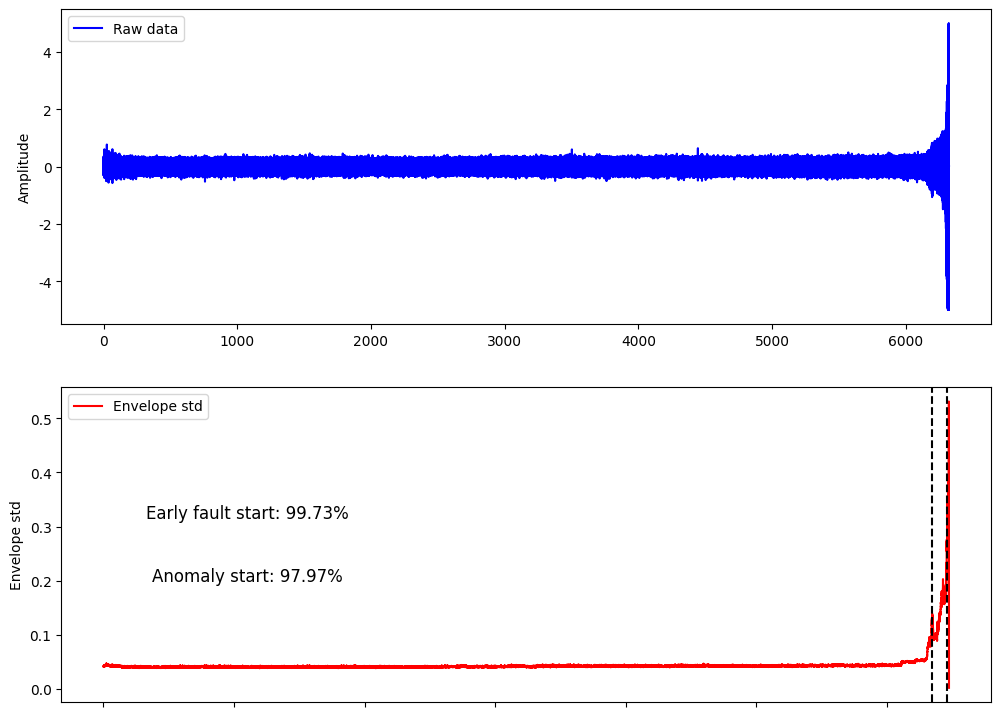

 33%|███▎      | 1/3 [01:44<03:29, 104.54s/it]

load/home/user/data/PHMbenchdata/RM_004_IMS/1st_test


100%|██████████| 2156/2156 [00:29<00:00, 72.29it/s]
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not fo

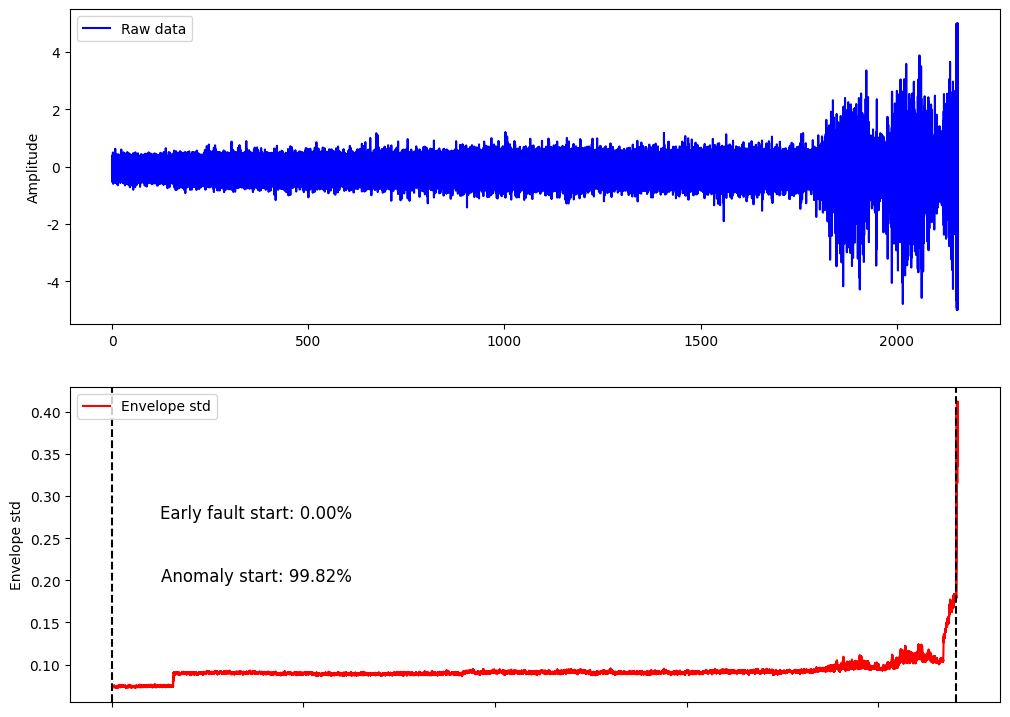

 67%|██████▋   | 2/3 [02:27<01:08, 68.45s/it] 

load/home/user/data/PHMbenchdata/RM_004_IMS/2nd_test


100%|██████████| 984/984 [00:09<00:00, 99.76it/s] 
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not fou

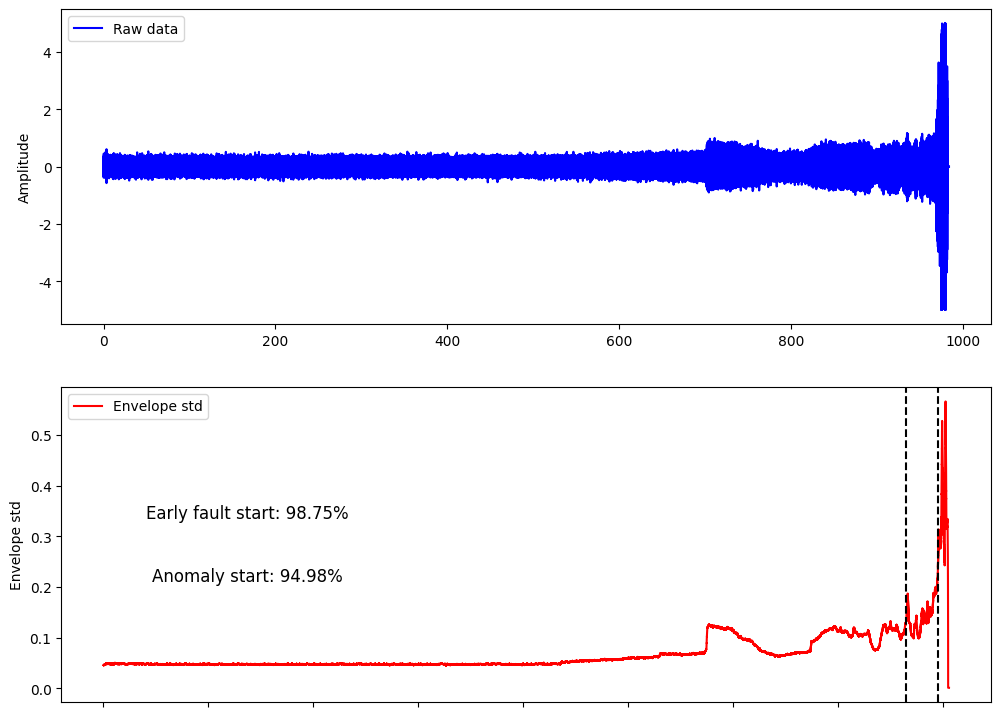

100%|██████████| 3/3 [02:45<00:00, 55.07s/it]


In [11]:
import os
import numpy as np
import pandas as pd
import glob
import re
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import multiprocessing as mp
import matplotlib.pyplot as plt
from tqdm import tqdm
import argparse
from scipy.signal import hilbert
from scipy.stats import kurtosis
from datetime import datetime

def load_csv(args, file_name):
    all_data = []

    if file_name == "1st_test":
        path_data = args.root_path + args.data_path + "1st_test"

    elif file_name == "2nd_test":
        path_data = args.root_path + args.data_path + "2nd_test"

    elif file_name == '4th_test':
        path_data = args.root_path + args.data_path + "4th_test/txt"

    # for i,target_bearing in enumerate(sorted(Learning_set)):
    #     if file_name == target_bearing:

    #         path_data = args.root_path + args.data_path +'Learning_set/' + file_name
    #         break  
    #     else:

    #         path_data = args.root_path + args.data_path +'Full_Test_Set/' + file_name    
                  
    all_file = os.listdir(path_data)
    all_file.sort(key=lambda l: datetime.strptime(l, '%Y.%m.%d.%H.%M.%S'))
    
    print('load' + f'{path_data}')
    for name in tqdm(all_file):
        if file_name == '1st_test':
            raw_data = pd.read_csv(os.path.join(path_data, name), sep='\t',header=None).loc[:,[4]]
        if file_name == '2nd_test':
            raw_data = pd.read_csv(os.path.join(path_data, name), sep='\t',header=None).loc[:,[0]]
        if file_name == '4th_test':
            raw_data = pd.read_csv(os.path.join(path_data, name), sep='\t',header=None).loc[:,[2]]

        
        all_data.append(raw_data)
    return all_data

def reshape_data(data):
    reshaped_data = pd.concat(data, axis=0, ignore_index=True)
    return reshaped_data


def plot_data(data, file, window_size=32768):
    # 计算包络谱的频域峭度
    # amplitude_envelope = pd.DataFrame(data[:])
    analytic_signal = hilbert(data)
    amplitude_envelope = pd.DataFrame(np.abs(analytic_signal[:]))
    # # spectrum, freqs, _, _ = plt.specgram(amplitude_envelope, NFFT=window_size, Fs=1, noverlap=0, mode='magnitude')
    # kurt = pd.DataFrame(spectrum).apply(kurtosis, raw=True)
    window_std = []
    for i in range(100):
        window = amplitude_envelope[i*window_size:(i+1)*window_size]
        std = window.std()
        window_std.append(std)
    std_base = np.mean(window_std)
    
    window_size = window_size
    std = amplitude_envelope.rolling(window_size).std()
    mean = amplitude_envelope.rolling(window_size).mean()
        
    # 找到第一个异常点
    threshold = 3 * std_base
    anomalies = abs(std) > threshold
    anomaly_start = anomalies.idxmax()

    # 找到第一个早期故障点
    
    threshold_fault = 6 * std_base
    anomalies_fault = abs(std) > threshold_fault
    fault_start = anomalies_fault.idxmax()
    
    
    
    # std = pd.DataFrame(amplitude_envelope).rolling(window_size).std()
    lenth = len(amplitude_envelope)
    time = lenth//window_size
    time = np.linspace(0, time,lenth)
    
    # 绘制原始信号和包络谱的频域峭度曲线
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 9))
    ax[0].plot(time,data.iloc[:,0], color='blue', label='Raw data')
    ax[0].set_ylabel('Amplitude')
    ax[0].legend(loc='upper left')
    
    ax[1].plot(std, color='red', label='Envelope std')
    ax[1].set_ylabel('Envelope std')
    ax[1].axes.xaxis.set_ticklabels([])

    ax[1].legend(loc='upper left')



    ax[1].axvline(anomaly_start[0], color='black', linestyle='--')
    # 保存图像为svg格式
    file_name = file.split('.')[0]
    
    ax[1].text(0.2, 0.4, 'Anomaly start: {:.2f}%'.format(anomaly_start[0] / lenth * 100),
             ha='center', va='center', transform=ax[1].transAxes, fontsize=12, color='black')
    ax[1].axvline(fault_start[0], color='black', linestyle='--')
    # 保存图像为svg格式
    file_name = file.split('.')[0]
    
    ax[1].text(0.2, 0.6, 'Early fault start: {:.2f}%'.format(fault_start[0] / lenth * 100),
             ha='center', va='center', transform=ax[1].transAxes, fontsize=12, color='black')

    
    # fig.savefig(file_name + f'ws{window_size}.svg', format='svg')

    plt.show()

# args = argparse.Namespace(
#     root_path='/home/richie_thu/_Richie_project/U-PHM/',
#     data_path='dataset/XJTU/',
#     dataset='XJTU',
#     batch_size=64,
#     shuffle_flag=True,
#     num_workers=0,
#     drop_last=True,
#     size=1024,
#     pred=1,
#     scale=True,
#     sample_freq=20480.0,
#     bearing = ['Bearing1_1','Bearing2_1','Bearing3_1'] + ['Bearing1_2','Bearing1_3','Bearing1_4','Bearing1_5',
#                         'Bearing2_2','Bearing2_3','Bearing2_4','Bearing2_5',
#                         'Bearing3_2','Bearing3_3','Bearing3_4','Bearing3_5']
# )
# for file in tqdm(args.bearing):
    
#     all_data = load_csv(args,file)
#     reshaped_data = reshape_data(all_data)
#     plot_data(reshaped_data,file)
    
args = argparse.Namespace(
    root_path='/home/user/data/PHMbenchdata/RM_004_IMS',
    data_path='/',
    dataset='IMS',
    batch_size=64,
    shuffle_flag=True,
    num_workers=0,
    drop_last=True,
    size=1024,
    pred=1,
    scale=True,
    sample_freq=20480.0,
    bearing = ['4th_test'] + ['1st_test','2nd_test']    
)
for file in tqdm(args.bearing):
    
    all_data = load_csv(args,file)
    reshaped_data = reshape_data(all_data)
    plot_data(reshaped_data,file,window_size=20480)
 



findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Generic family 'serif' not found because none of the following families were foun

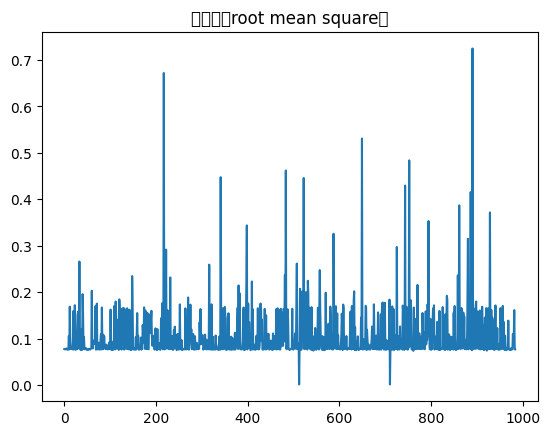

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams
config = {
    "font.family": 'serif',  # 衬线字体
    "font.size": 10,  # 相当于小四大小
    "font.serif": ['SimSun'],  # 宋体
    "mathtext.fontset": 'stix',  # matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
    'axes.unicode_minus': False  # 处理负号，即-号
}
rcParams.update(config)
def get_RMS(data):
    x = data
    X_mean = np.mean(x)
    x = x - X_mean  # 零均值化（去直流分量）
    X_rms2 = np.sum(x ** 2) / len(x)  # 3.均方值
    X_rms = np.sqrt(X_rms2)  # 4.均方根值(有效值)

    time_fea_list = [X_rms]
    time_domain_names_list = ['均方根（root mean square）']
    return time_fea_list, time_domain_names_list

def IMF_data_acquisition(file_path, n):
    """
    fun: 从IMF文件读取加速度数据
    param file_path: mat文件绝对路径
    return accl_data: 加速度数据，array类型
    """
    data = np.loadtxt(fname=file_path)
    accl_data = data[:, n]
    return accl_data


base_dir = '/home/user/data/a_bearing/a_004_IMS_raw/2nd_test'
file_name_list = os.listdir(base_dir)
all_time_domain_features_list = []

for file_name in file_name_list:
    file_path = os.path.join(base_dir, file_name)
    data = IMF_data_acquisition(file_path=file_path, n=0)
    time_domain_features_list, time_domain_names_list = get_RMS(data=data)
    all_time_domain_features_list.append(time_domain_features_list)

all_time_domain_features_arr = np.array(all_time_domain_features_list)

feature_idx = 0  # Index of the RMS feature

plt.plot(all_time_domain_features_arr[:, feature_idx], label='RMS')
plt.title(time_domain_names_list[feature_idx])
plt.show()
